In [ ]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
'''
@Env     		:   grizli
@File    		:   ~/emulator/emissionline_detect.ipynb
@Time    		:   2023/06/28 20:44:28
@Author  		:   Run Wen
@Version 		:   1.0
@Contact 		:   wenrun@pmo.ac.cn
@Description	:   Using "specutils" to detect emission lines in spectra
'''


In [2]:
import numpy as np
from astropy.table import Table
import re
import os
import h5py
import math
import pysynphot as S
from matplotlib.ticker import FuncFormatter,NullFormatter
import matplotlib.ticker as ticker
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy import units as u
from specutils.spectra import Spectrum1D
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_generic_continuum
import specutils
import warnings
warnings.filterwarnings("ignore")

specutils.conf.do_continuum_function_check = False
matplotlib.rcParams['figure.figsize'] = [8, 4]

/Users/rain/miniconda3/envs/grizli/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/rain/grizli/synphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
hdf5 = h5py.File('/Users/rain/emulator/emulator_v0.6/seedcat2_0420_0_DECaLS_0csp_sfh200_bc2003_hr_stelib_chab_neb_300r_i0100_2dal8_10_inoise0.hdf5')
cat = h5py.File('/Users/rain/emulator/emulator_v0.6/CSST_grism_10000_seedcat2_0420_0_DECaLS_0csp_sfh200_bc2003_hr_stelib_chab_neb_300r_i0100_2dal8_10_inoise0.hdf5')
bkg = h5py.File('/Users/rain/emulator/bkg_and_tp.hdf5', 'r')
csstgu = S.ArrayBandpass(bkg['bkg_gu_wave'][:],bkg['bkg_gu_throughput'][:])
csstgv = S.ArrayBandpass(bkg['bkg_gv_wave'][:],bkg['bkg_gv_throughput'][:])
csstgi = S.ArrayBandpass(bkg['bkg_gi_wave'][:],bkg['bkg_gi_throughput'][:])
gutp = bkg['bkg_gu_throughput'][:]
gvtp = bkg['bkg_gv_throughput'][:]
gitp = bkg['bkg_gi_throughput'][:]

In [4]:
def el_detect(wave,flux,init_wave,end_wave,threshold):
    """ 
    Detect emission lines in the spectra using 'find_lines_derivative' function in specutils package.

    features:
    --------
    Using 'find_lines_derivative' function to derive emission lines with a normalized spectra ( spectrum/fitted_continuum )
    Choosing the initial and end index of wavelength grid to avoid the extremely noisy region at the end of each spectra.
    wavelength unit should be in angstrom while flux unit should be in Jy.
    Different threshold can result in different line detections results, please have some test before choosing the reasonable threshold.

    parameters:
    ----------
    wave - wavelength grid of the galaxy - [array]
    flux - flux grid of the galaxy - [array]
    init_wave - the initial index in wavelength grid - [int]
    end_wave - the end index in wavelength grid - [int]
    # x_unit - the unit used in modeling specutils.spectrum for wavelength, recommanding 'angstrom'
    # y_unit - the unit used in modeling specutils.spectrum for flux, recommanding 'Jy'
    threshold - threshold of the 'find_lines_derivative'

    return:
    ------
    lines - effective radius of the galaxy in pix
    """
    x = wave[init_wave:end_wave]
    y = flux[init_wave:end_wave]

    spectrum = Spectrum1D(flux=y*u.uJy, spectral_axis=x*u.angstrom)
    g1_fit = fit_generic_continuum(spectrum)
    mean = np.mean(spectrum.flux)
    continumm = spectrum.flux[np.argmin(np.abs(spectrum.flux - mean))]

    y_continuum_fitted = g1_fit(x*u.angstrom)
    y_continuum_fitted[y_continuum_fitted < continumm] = continumm
    spec_normalized = spectrum / y_continuum_fitted
    lines = find_lines_derivative(spec_normalized, flux_threshold=threshold)  

    return lines

In [5]:
noisy_lines = []
intrinsic_lines = []
for i in tqdm(range(len(cat['ID'][:]))):
    noisy_lines.append(el_detect(cat['gi_wave'][:],cat['gi_fnu_with_noise'][i],10,310,1.5))
    intrinsic_lines.append(el_detect(cat['gi_wave'][:],cat['gi_fnu'][i],10,310,1.2))

100%|██████████| 10000/10000 [05:24<00:00, 30.84it/s]


In [6]:
len(noisy_lines)

10000

In [7]:
noisy_len = []
intrinsic_len = []
for i in range(len(noisy_lines)):
    noisy_len.append(len(noisy_lines[i]))
    intrinsic_len.append(len(intrinsic_lines[i]))

Text(0.5, 1.0, 'intrinsic spectra EL detection distribution')

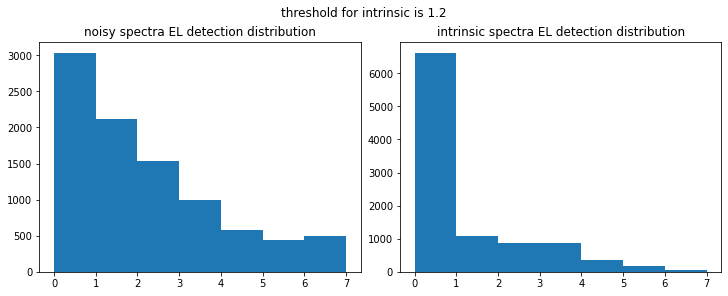

In [9]:
matplotlib.rcParams['figure.figsize'] = [10, 4]
fig, ax = plt.subplots(ncols=2, nrows=1, layout='constrained')
plt.suptitle('threshold for intrinsic is 1.2')
ax[0].hist(noisy_len,bins=np.arange(0,8,1))
ax[0].set_title('noisy spectra EL detection distribution')
ax[1].hist(intrinsic_len,bins=np.arange(0,8,1))
ax[1].set_title('intrinsic spectra EL detection distribution')


Text(0.5, 1.0, 'intrinsic spectra EL detection distribution')

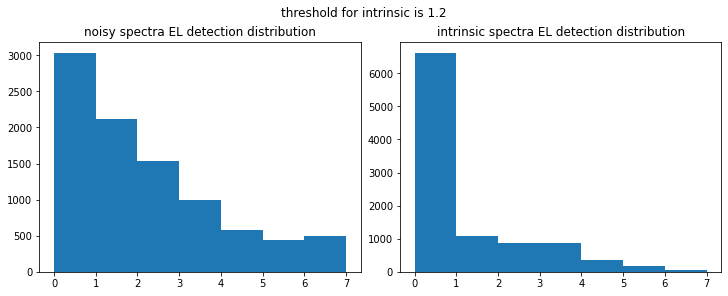

In [10]:
matplotlib.rcParams['figure.figsize'] = [10, 4]
fig, ax = plt.subplots(ncols=2, nrows=1, layout='constrained')
plt.suptitle('threshold for intrinsic is 1.2')
ax[0].hist(noisy_len,bins=np.arange(0,8,1))
ax[0].set_title('noisy spectra EL detection distribution')
ax[1].hist(intrinsic_len,bins=np.arange(0,8,1))
ax[1].set_title('intrinsic spectra EL detection distribution')


In [11]:
def el_success(noisy,intri,threshold):
    """ 
    Detect emission lines in two QTable created by specutils

    features:
    --------
    Using 'find_lines_derivative' function to derive emission lines with a normalized spectra ( spectrum/fitted_continuum )
    Choosing the initial and end index of wavelength grid to avoid the extremely noisy region at the end of each spectra.
    wavelength unit should be in angstrom while flux unit should be in Jy.
    Different threshold can result in different line detections results, please have some test before choosing the reasonable threshold.

    parameters:
    ----------
    noisy - QTable with emission lines detection from simulated noisy spectra - [QTable]
    intri - QTable with emission lines detection from simulated intrinsic spectra - [QTable]
    threshold - threshold of the emission line center wavelength between noisy and intrinsic spectra - [float]

    return:
    ------
    intrinsic_el_arr - the emission line detection imformation array from intrinsic spectra, this result shows the total emission-line galaxies 
                       satisfying the 'find_lines_derivative' method in the corresponding hdf5. - [array]
    final_detec_el - the emission line detection imformation array from noisy spectra and satisfies the threshold of 'line_center' compared with 
                     intrinsic spectra (typicallly 1 PSF, 0.3 arcsec, 50 angstrom?). - [array]
    success_rate - the successful emission line detection rate from noisy spectra compared with intrinsic spectra - [float]
    """
    
    intrinsic_el_list = []
    success_detect_list = []
    dtype1 = [('id', int), ('wave', list), ('idx', list)]
    dtype2 = [('id', int), ('wave', list), ('idx', list), ('el_number', int)]

    for i in tqdm(range(len(noisy))):
        if len(noisy[i]) == 0:
            pass
        elif len(noisy[i]) >= 1:
            if len(noisy[i][noisy[i]['line_type'] == 'emission']) !=0:

                noisy_wave = noisy[i][noisy[i]['line_type'] == 'emission']['line_center'][:] # wave
                noisy_wave_idx = noisy[i][noisy[i]['line_type'] == 'emission']['line_center_index'][:] # idx

                if len(intri[i]) == 0:
                    pass
                elif len(intri[i]) >= 1:

                    intri_wave = intri[i][intri[i]['line_type'] == 'emission']['line_center'][:] # wave
                    intri_wave_idx = intri[i][intri[i]['line_type'] == 'emission']['line_center_index'][:] # idx
                    elnumber1 = len(intri_wave)   
                    data1 = np.array([(i, list(intri_wave.value), list(intri_wave_idx), elnumber1)],dtype=dtype2)
                    intrinsic_el_list.append(data1)

                    elnumber2 = 0
                    for j in range(len(noisy_wave)):
                        for k in range(len(intri_wave)):
                            if abs(noisy_wave[j].value-intri_wave[k].value) <= threshold:
                                elnumber2+=1
                                data2 = np.array([(i, list(noisy_wave.value), list(noisy_wave_idx), elnumber2)],dtype=dtype2)
                                success_detect_list.append(data2)
    intri_el_arr = np.array(intrinsic_el_list)
    intrinsic_el_arr = np.squeeze(intri_el_arr)

    success_detect_arr = np.array(success_detect_list)
    new_detect_el = []
    unique_ids = np.unique(success_detect_arr['id'])
    for i, uid in enumerate(unique_ids):
        index = np.where(success_detect_arr['id'] == uid)
        eln_value = np.max(success_detect_arr['el_number'][index])
        new_detect_el.append(success_detect_arr[index][eln_value-1])
    final_detec_el = np.array(new_detect_el)

    # success_rate = len(final_detec_el)/len(intrinsic_el_arr)

    return intrinsic_el_arr, final_detec_el #, success_rate

In [12]:
intri_with_el, detect_el = el_success(noisy_lines,intrinsic_lines,50)

100%|██████████| 10000/10000 [00:02<00:00, 4760.64it/s]


In [13]:
len(intri_with_el)
intri_with_el

array([(   2, list([7186.501393170599, 9379.743969557454, 9661.915529092606]), list([79, 250, 272]), 3),
       (   4, list([7994.538131839441, 8199.753811501369, 8699.967030677319]), list([142, 158, 197]), 3),
       (   7, list([6929.981793593189, 9341.266029620843]), list([59, 247]), 2),
       ...,
       (9995, list([7609.758732473326, 9969.739048585498]), list([112, 296]), 2),
       (9996, list([8097.145971670405, 9059.094470085693, 9341.266029620843]), list([150, 225, 247]), 3),
       (9997, list([7301.935212980434, 9854.305228775664]), list([88, 287]), 2)],
      dtype=[('id', '<i8'), ('wave', 'O'), ('idx', 'O'), ('el_number', '<i8')])

In [14]:
intri_with_el[4]

(27, list([6711.94013395239, 6917.1558136143185, 9059.094470085693]), list([42, 58, 225]), 3)

In [15]:
intri_with_el.shape

(3135,)

In [16]:
len(detect_el)
detect_el

array([(   2, list([7186.501393170599, 8853.878790423765, 9405.395929515196, 9815.827288839053, 9867.131208754534, 9944.087088627757]), list([79, 209, 252, 284, 288, 294]), 2),
       (   4, list([7994.538131839441, 8199.753811501369]), list([142, 158]), 2),
       (   7, list([6929.981793593189, 9341.266029620843]), list([59, 247]), 2),
       ...,
       (9990, list([7237.805313086081, 9469.525829409547]), list([83, 257]), 2),
       (9995, list([7609.758732473326, 9956.913068606627]), list([112, 295]), 2),
       (9997, list([7301.935212980434, 9854.305228775664]), list([88, 287]), 2)],
      dtype=[('id', '<i8'), ('wave', 'O'), ('idx', 'O'), ('el_number', '<i8')])

In [1092]:
"""
How to store the result as hdf5 file

"""
import h5py
import numpy as np

arr = np.array([(2, [7186.501393170599, 9379.743969557454, 9661.915529092606], [79, 250, 272], 3),
                (4, [7994.538131839441, 8199.753811501369, 8699.967030677319], [142, 158, 197], 3),
                (6, [7699.540592325419], [119], 1),
                (9995, [7609.758732473326, 9969.739048585498], [112, 296], 2),
                (9996, [8097.145971670405, 9059.094470085693, 9341.266029620843], [150, 225, 247], 3),
                (9997, [7301.935212980434, 9854.305228775664], [88, 287], 2)],
               dtype=[('id', '<i8'), ('wave', 'O'), ('idx', 'O'), ('el_number', '<i8')])

with h5py.File('data.hdf5', 'w') as f:
    # 存储整数列
    f.create_dataset('id', data=arr['id'])
    f.create_dataset('el_number', data=arr['el_number'])
    
    # 存储 dtype 为 'O' 的列
    dt = h5py.special_dtype(vlen=np.dtype('float64'))
    wave_dset = f.create_dataset('wave', (len(arr),), dtype=dt)
    wave_dset[:] = arr['wave']
    
    dt = h5py.special_dtype(vlen=np.dtype('int64'))
    idx_dset = f.create_dataset('idx', (len(arr),), dtype=dt)
    idx_dset[:] = arr['idx']


In [1093]:
test = h5py.File('data.hdf5','r')

In [1094]:
test.keys()

<KeysViewHDF5 ['el_number', 'id', 'idx', 'wave']>

In [1096]:
print(test['el_number'][:])
print(test['id'][:])
print(test['idx'][:])
print(test['wave'][:])


[3 3 1 2 3 2]
[   2    4    6 9995 9996 9997]
[array([ 79, 250, 272]) array([142, 158, 197]) array([119])
 array([112, 296]) array([150, 225, 247]) array([ 88, 287])]
[array([7186.50139317, 9379.74396956, 9661.91552909])
 array([7994.53813184, 8199.7538115 , 8699.96703068])
 array([7699.54059233]) array([7609.75873247, 9969.73904859])
 array([8097.14597167, 9059.09447009, 9341.26602962])
 array([7301.93521298, 9854.30522878])]


In [18]:
z_success = np.zeros(len(noisy_lines))
z_success

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
intri_with_el['id']

array([   2,    4,    7, ..., 9995, 9996, 9997])

In [20]:
detect_el['id']

array([   2,    4,    7, ..., 9990, 9995, 9997])

In [21]:
for i in range(len(noisy_lines)):
    if i in intri_with_el['id']:
        z_success[i] = 1
        if i in detect_el['id']:
            z_success[i] = 2
    elif i not in intri_with_el['id']:
        z_success[i] = 0

In [22]:
z_success

array([0., 0., 2., ..., 2., 0., 0.])

In [23]:
k=0
for i, vlu in enumerate(z_success):
    if vlu == 1:
        k+=1
        print(i)
print(k)

49
91
92
123
128
147
177
208
220
352
360
367
370
371
393
476
477
507
514
537
554
581
593
606
662
683
697
698
723
732
752
763
804
805
818
857
911
915
917
926
930
933
943
952
974
986
995
1002
1016
1017
1026
1031
1081
1108
1116
1134
1145
1154
1156
1160
1166
1169
1189
1191
1211
1216
1229
1233
1248
1330
1375
1394
1397
1418
1422
1431
1460
1477
1485
1507
1518
1537
1573
1602
1605
1675
1677
1698
1711
1750
1785
1805
1813
1835
1842
1859
1863
1867
1936
1978
2032
2045
2052
2060
2061
2073
2114
2123
2151
2197
2234
2258
2274
2275
2284
2299
2313
2314
2325
2351
2363
2432
2457
2467
2487
2509
2518
2536
2541
2556
2572
2583
2648
2659
2675
2687
2712
2729
2736
2758
2794
2796
2848
2881
2901
2993
3007
3014
3019
3029
3051
3083
3107
3118
3127
3135
3145
3180
3233
3236
3245
3265
3325
3358
3376
3385
3426
3441
3483
3549
3606
3608
3613
3635
3663
3667
3682
3787
3801
3840
3873
3922
3928
3980
4000
4001
4007
4049
4079
4095
4114
4132
4137
4139
4175
4274
4288
4295
4314
4355
4418
4424
4425
4445
4479
4498
4510
4529
4532
4546


In [24]:
469+2666

3135

In [27]:
noisy_lines[idx]

line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
6929.981793593189,emission,59
9341.266029620843,emission,247


[]


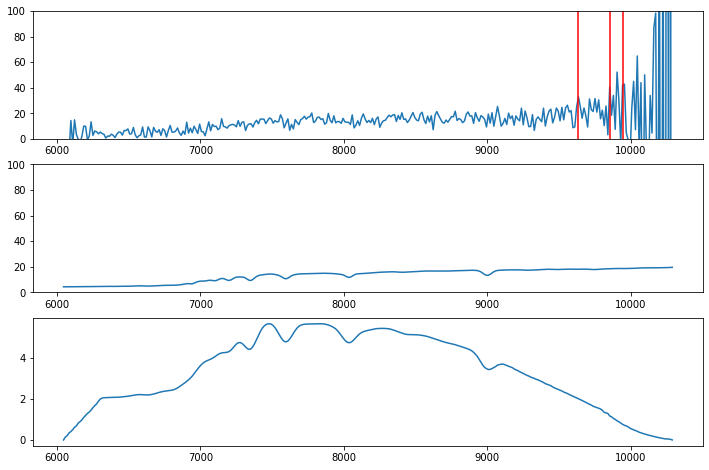

In [113]:
idx = 1456
matplotlib.rcParams['figure.figsize'] = [12, 8]
fig,ax = plt.subplots(3,1)
ax[0].plot(cat['gi_wave'][:],cat['gi_fnu_with_noise'][idx])
ax[0].set_ylim(0,100)
for i in range(len(noisy_lines[idx])):
    ax[0].axvline(cat['gi_wave'][noisy_lines[idx][:][i][2]+10],c='r')

ax[1].plot(cat['gi_wave'][:],cat['gi_fnu'][idx])
ax[1].set_ylim(0,100)
for i in range(len(intrinsic_lines[idx])):
    ax[1].axvline(cat['gi_wave'][intrinsic_lines[idx][:][i][2]+10],c='r')
    
ax[2].plot(cat['gi_wave'][:],cat['gi_snr'][idx])
# ax[2].axhline(cat['gi_snr'][idx].mean())
print(detect_el['el_number'][detect_el['id']==idx])

In [81]:
def get_el_snr(snr,flag,detect_el,init_wave_idx):
    snr_detect_list = []
    # el_mean_snr = []
    snr_list = snr[flag==2]
    for idx1 in range(len(detect_el)):
        el_mean_snr = []
        for idx2 in range(len(detect_el['idx'][idx1])):
            elidx = init_wave_idx+detect_el['idx'][idx1][idx2]
            elwidth = 30 # in index
            el_mean_snr.append((snr_list[idx1][elidx-round(elwidth/2) : elidx+round(elwidth/2)]).mean())
        # data = np.array([(el_mean_snr)], dtype=[('el_mean_snr', float)])
        snr_detect_list.append(el_mean_snr)
    snr_detect_arr = np.array(snr_detect_list)
    return snr_detect_arr

In [88]:
get_el_snr(cat['gi_snr'][:],z_success,detect_el,10)

array([list([3.122047028492964, 2.359194308387778, 1.5952671141778956, 0.6816463131378714, 0.5561439522857118, 0.3874376023249922]),
       list([48.37682725488458, 42.6838483858841]),
       list([27.431890618985765, 32.02865687740623]), ...,
       list([18.601049714826956, 10.09261165162766]),
       list([11.793673108906741, 2.076331069055863]),
       list([12.288952682452512, 9.213392602860704])], dtype=object)

In [70]:
detect_el

array([(   2, list([7186.501393170599, 8853.878790423765, 9405.395929515196, 9815.827288839053, 9867.131208754534, 9944.087088627757]), list([79, 209, 252, 284, 288, 294]), 2),
       (   4, list([7994.538131839441, 8199.753811501369]), list([142, 158]), 2),
       (   7, list([6929.981793593189, 9341.266029620843]), list([59, 247]), 2),
       ...,
       (9990, list([7237.805313086081, 9469.525829409547]), list([83, 257]), 2),
       (9995, list([7609.758732473326, 9956.913068606627]), list([112, 295]), 2),
       (9997, list([7301.935212980434, 9854.305228775664]), list([88, 287]), 2)],
      dtype=[('id', '<i8'), ('wave', 'O'), ('idx', 'O'), ('el_number', '<i8')])

In [ ]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
fig,ax = plt.subplots(3,1)
ax[0].plot(cat['gi_wave'][:],cat['gi_fnu_with_noise'][idx])
ax[0].set_ylim(0,100)
for i in range(len(noisy_lines[idx])):
    ax[0].axvline(cat['gi_wave'][noisy_lines[idx][:][i][2]+10],c='r')
ax[1].plot(cat['gi_wave'][:],cat['gi_fnu'][idx])
ax[1].set_ylim(0,100)
for i in range(len(intrinsic_lines[idx])):
    ax[1].axvline(cat['gi_wave'][intrinsic_lines[idx][:][i][2]+10],c='r')
ax[2].plot(cat['gi_wave'][:],cat['gi_snr'][idx])
ax[2].axhline(cat['gi_snr'][idx].mean())

(0.0, 1.0)

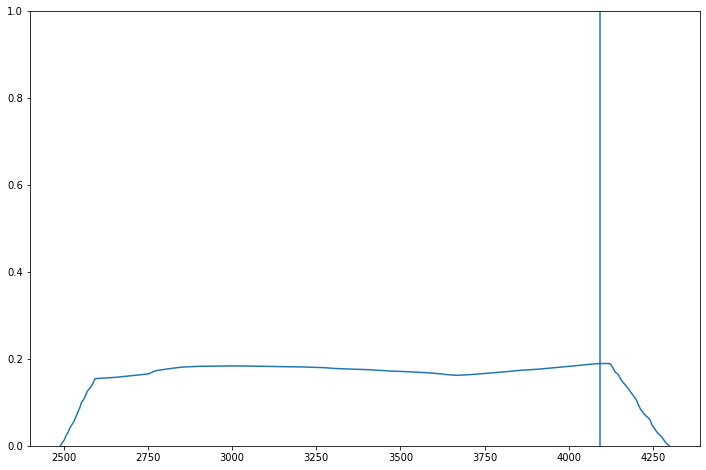

In [899]:
plt.plot(bkg['bkg_gu_wave'][:],bkg['bkg_gu_throughput'][:])
plt.axvline(bkg['bkg_gu_wave'][280])
plt.ylim(0,1)

(0.0, 1.0)

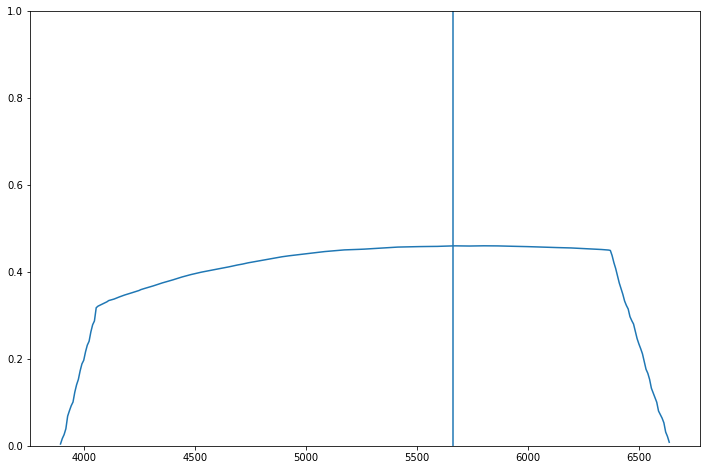

In [896]:
plt.plot(bkg['bkg_gv_wave'][:],bkg['bkg_gv_throughput'][:])
plt.axvline(bkg['bkg_gv_wave'][220])
plt.ylim(0,1)

(0.0, 1.0)

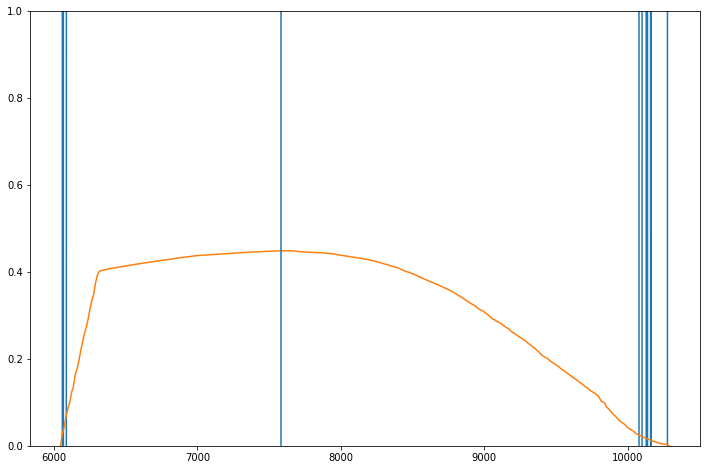

In [831]:
plt.plot(cat['gi_wave'][:],cat['gi_fnu_with_noise'][idx])
plt.plot(bkg['bkg_gi_wave'][:],bkg['bkg_gi_throughput'][:])
plt.axvline(bkg['bkg_gi_wave'][120])
plt.ylim(0,1)

In [821]:
bkg.keys()

<KeysViewHDF5 ['bkg_flam_per_arcsec', 'bkg_gi_fnu_per_arcsec', 'bkg_gi_throughput', 'bkg_gi_wave', 'bkg_gu_fnu_per_arcsec', 'bkg_gu_throughput', 'bkg_gu_wave', 'bkg_gv_fnu_per_arcsec', 'bkg_gv_throughput', 'bkg_gv_wave', 'bkg_wave']>

In [832]:
cat['gi_fnu_with_noise'][:,120]

array([11.07827206, 27.52285866, 13.79632539, ..., 26.0219073 ,
       16.34395849, 23.87212041])

In [833]:
def uJy2mAB(flux): return -2.5*np.log10(flux)+23.9

(array([3.000e+00, 6.000e+01, 5.310e+02, 3.589e+03, 2.783e+03, 7.100e+02,
        1.550e+02, 3.400e+01, 1.200e+01, 2.000e+00]),
 array([16.12563887, 17.68514679, 19.24465471, 20.80416262, 22.36367054,
        23.92317845, 25.48268637, 27.04219428, 28.6017022 , 30.16121011,
        31.72071803]),
 <BarContainer object of 10 artists>)

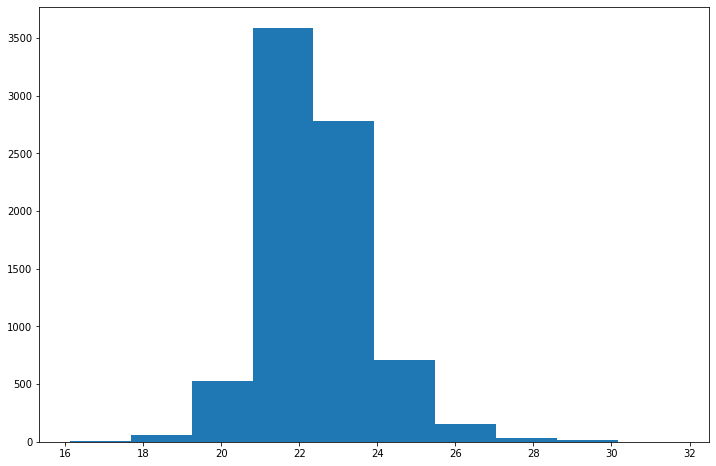

In [901]:
plt.hist(uJy2mAB(cat['gu_fnu_with_noise'][:,220]))

(array([2.000e+00, 2.000e+01, 2.560e+02, 1.043e+03, 4.028e+03, 3.483e+03,
        6.410e+02, 1.000e+02, 2.800e+01, 3.000e+00]),
 array([14.05409527, 15.5271045 , 17.00011374, 18.47312297, 19.94613221,
        21.41914144, 22.89215067, 24.36515991, 25.83816914, 27.31117838,
        28.78418761]),
 <BarContainer object of 10 artists>)

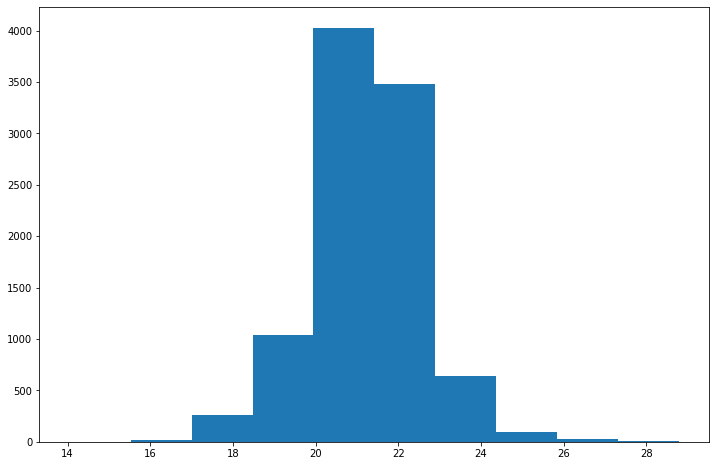

In [900]:
plt.hist(uJy2mAB(cat['gv_fnu_with_noise'][:,220]))

(array([5.000e+00, 1.500e+01, 1.800e+02, 5.820e+02, 2.239e+03, 5.548e+03,
        1.320e+03, 7.300e+01, 1.100e+01, 2.000e+00]),
 array([14.00352362, 15.20556458, 16.40760553, 17.60964649, 18.81168744,
        20.0137284 , 21.21576936, 22.41781031, 23.61985127, 24.82189222,
        26.02393318]),
 <BarContainer object of 10 artists>)

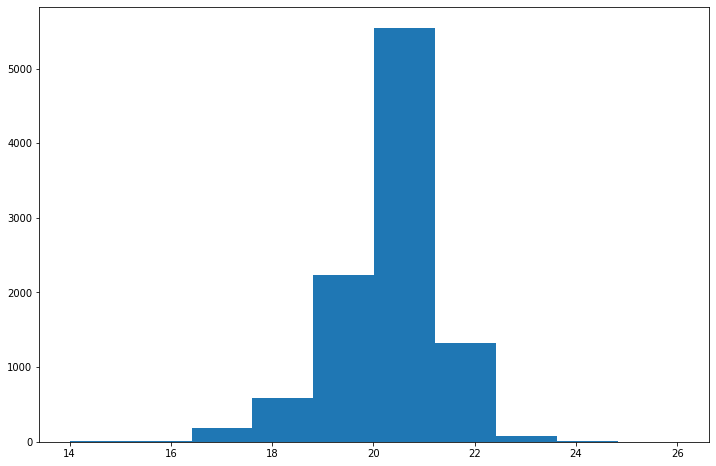

In [838]:
plt.hist(uJy2mAB(cat['gi_fnu_with_noise'][:,120]))

In [855]:
gimag = np.around(uJy2mAB(cat['gi_fnu_with_noise'][:,120]),decimals=2)

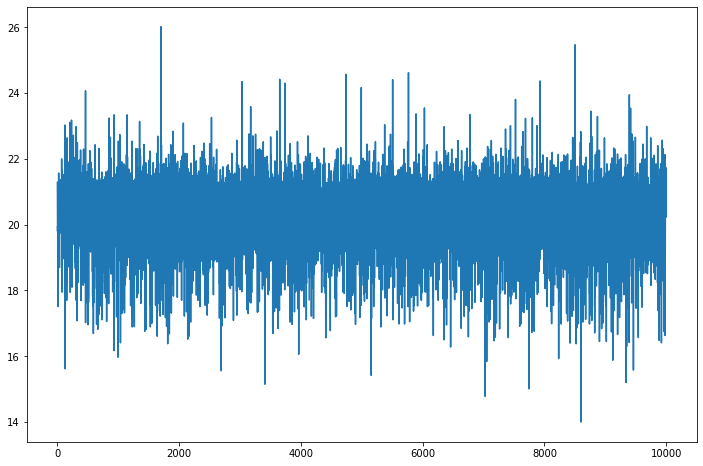

In [856]:
plt.plot(gimag)

In [857]:
np.array(gimag)

array([21.29, 20.3 , 21.05, ..., 20.36, 20.87, 20.46])

In [858]:
np.array([0,1,2,3]).max()

3

In [864]:
min(gimag)

14.0

In [862]:
gimag[1]

20.3

b'z_{mean}'
b'z_{median}'
b'z_{MAP}'
b'z_{MAL}'
b'log(M*)[0,1]_{mean}'
b'log(M*)[0,1]_{median}'
b'log(M*)[0,1]_{MAP}'
b'log(M*)[0,1]_{MAL}'
b'log(SFR_100Myr/[M_{sun}/yr])[0,1]_{mean}'
b'log(SFR_100Myr/[M_{sun}/yr])[0,1]_{median}'
b'log(SFR_100Myr/[M_{sun}/yr])[0,1]_{MAP}'
b'log(SFR_100Myr/[M_{sun}/yr])[0,1]_{MAL}'
b'log(H1_6562.81)[0,1]_{mean}'
b'log(H1_6562.81)[0,1]_{median}'
b'log(H1_6562.81)[0,1]_{MAL}'
b'log(H1_6562.81)[0,1]_{MAP}'
b'log(H1_4861.33)[0,1]_{mean}'
b'log(H1_4861.33)[0,1]_{median}'
b'log(H1_4861.33)[0,1]_{MAL}'
b'log(H1_4861.33)[0,1]_{MAP}'
b'E(B-V)'


In [1100]:
extract_param[0]

b'z_{mean}'